In [1]:
import os
import importlib
import logging
importlib.reload(logging)
import framework
importlib.reload(framework)
import infer_bert_classifier
importlib.reload(infer_bert_classifier)
import bert_utils
importlib.reload(bert_utils)
from framework import *
import pandas as pd
import time
# Define some constants and configurations
logging.getLogger().setLevel(logging.INFO)

ACCESS_TOKEN = 'WUpGevbWC9lsnTW8quNUtmWRdAEM89'

Using TensorFlow backend.


Set up the task details. This notebook handles NER (for labeling person and company names)

In [2]:
DATASET = 'omf-paystubs' # supports w2 and resume
TASK_CONFIG = {
    'task': 'cmp_name',
}

task = Task(TASK_CONFIG)

Set paths for datasets and goldens (local or ib, both work).
Specify configurations

In [3]:
OMF_DATA = [
    'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch2/out/s3_map_records/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch3/out/s1_process_files/',
    # 'ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch4/out/s1_process_files/'
]
OMF_GOLDEN = [
    './omf_batch_1.csv',
    # './omf_batch_2.csv',
    # './omf_batch_3.csv',
    # './omf_batch_4.csv'
]

GOLDEN_CONFIG = {
    'path': OMF_GOLDEN,
    'is_local': True,
    'index_field_name':'filename',
    'file_type': 'csv',
    'identifier': 'file'
}
DATASET_CONFIG = {
    'path': OMF_DATA,
    'is_local': False, 
    'file_type': 'ibdoc',
    'identifier': lambda path: os.path.basename(path).split('.ibdoc')[0],
    'convert2txt': False
}


data = DataCuration(ACCESS_TOKEN, DATASET_CONFIG, GOLDEN_CONFIG)

INFO:root:Loading dataset from ib_sales/OMF/fs/Instabase%20Drive/test/other-paystubs/Batch1/out/s3_map_records/
INFO:root:101 files loaded
INFO:root:Loading goldens from ./omf_batch_1.csv
INFO:root:Goldens have non-unique filenames, keeping only the first values
INFO:root:Total files Goldens: (117, 17)
INFO:root:Total files found in the source with unique index: (101, 17)


In [4]:
# ToDo: add ModelSelection() hyperparameter search in the framework

DATA_ARGS = {
    'task': task,
    'dataset': data,
     'candidates_fields': {
        'person':'employee_name',
        'org':'employer_name'
    },
    'data_config': {
        'max_num_tokens': 5,
        'max_token_distance': None,
        'embedding_type': 'bert',
        'cardinal_only': False,
        'balance_targets': True,
        'additional_features': [],
        'pre_processing': ['lower_case', 'remove_punc']
    }
}

TRAINING_ARGS = {
    'batch_size': 32,
    'epochs': 25, 
}


fe = FeatureEngineering_MLP(DATA_ARGS)
samples = fe.create_train_test_data()
print('Input shape: {}'.format(samples[0].shape))


INFO:root:Building BERT Model embeddings using pretrained model
INFO:root:Finished Loading Model, computing embeddings
Input shape: (578, 31488)


In [9]:
# Neural network
model_architecture = Sequential()
model_architecture.add(Dense(512, input_dim=samples[0].shape[1], activation='relu'))
model_architecture.add(Dropout(0.5))
model_architecture.add(Dense(128, activation='relu'))
model_architecture.add(Dropout(0.5))
model_architecture.add(Dense(1, activation='sigmoid'))
model_architecture.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model = MLP(DATA_ARGS, TRAINING_ARGS, model_architecture)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.


INFO:root:Training multilayer perceptron model for 578 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Train on 578 samples, validate on 248 samples
Epoch 1/25
578/578 [==============================] - 3s 6ms/step - loss: 2.9220 - accuracy: 0.5709 - val_loss: 0.8000 - val_accuracy: 0.6613
Epoch 2/25
578/578 [==============================] - 3s 5ms/step - loss: 1.7002 - accuracy: 0.6298 - val_loss: 0.5813 - val_accuracy: 0.7177
Epoch 3/25
578/578 [==============================] - 3s 5ms/step - loss: 1.0590 - accuracy: 0.6817 - val_loss: 0.6135 - val_accuracy: 0.6895
Epoch 4/25
578/578 [==============================] - 3s 5ms/step - loss: 0.9556 - accuracy: 0.6713 - val_loss: 0.5457 - val_accuracy: 0.7540
Epoch 5/25
578/578 [==============================] - 3s 5ms/step - loss: 0.7754 - accuracy: 0.7145 - val_loss: 0.5431 - val_accuracy: 0.7460
Epoch 6/25
578/578 [==============================] - 3s 5ms/step - loss: 0.6152 - ac

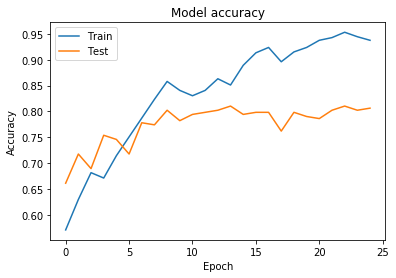

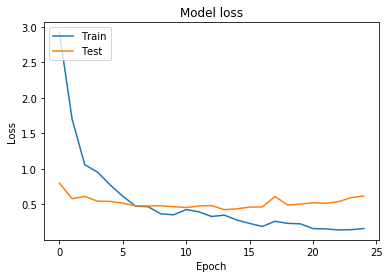

INFO:root:Accuracy is 0.8064516186714172


In [10]:
model.train(*samples)
acc = model.evaluate()
logging.info("Accuracy is {}".format(acc))

In [11]:
found_companies = model.predict()
print(found_companies)

_18_.pdf
INFO:root:Running predictions for file: APPELF__0885-000000009029560-08852811_&I100PYSTB_20191011153100_13000122-09029560-08852811-004_20_.pdf
INFO:root:Running predictions for file: APPELF__0887-000000009034880-08872971_&I100PYSTB_20191030172024_13000124-09034880-08872971-001_7_.pdf
INFO:root:Running predictions for file: APPELF__0889-000000009037450-08892941_&I100PYSTB_20191022031746_13000126-09037450-08892941-001_35_.pdf
INFO:root:Running predictions for file: APPELF__0891-000000009020280-08912971_&I100PYSTB_20191024082513_13000128-09020280-08912971-001_25_.pdf
INFO:root:Running predictions for file: APPELF__0893-000000009019970-08932881_&I100PYSTB_20191015195851_13000131-09019970-08932881-001_12_.pdf
{'APPELF__0089-000000009025750-00892881_&I100PYSTB_20191017005144_01000059-09025750-00892881-001_19_.pdf': ['Warrior Met Coal Mining, LLC', 'L. Tucker', 'Warrior Met Coal Mining,', 'Wells Fargo', 'Wells Fargo'], 'APPELF__0093-000000009062560-00932811_&I100PYSTB_20191009185526_

In [12]:
model.analyze_result(found_companies)
model.demo()

01_19_.pdf
	 Found:
		Warrior Met Coal Mining, LLC
		L. Tucker
		Warrior Met Coal Mining,
		Wells Fargo
		Wells Fargo
	 Expected:
		Warrior Met Coal Mining, LLC
01_20_.pdf
	 Found:
		FILE #
		Maricopa County
	 Expected:
		Maricopa County
02_26_.pdf
	 Found:
		Deer Valley Unified School District #97
		DEPOSIT RECEIPT
		Deer Valley Unified School District #97
		RENEE MARTINE
		ADAD SPLOVEE
	 Expected:
		Deer Valley Unified School District #97
001_2_.pdf
	 Found:
		Uta Carlotta Garrett
		GRay Tupe:
		EIX/SCE BI-WEEKLY
		Southern CA Edison
		Grove Ave. Rosemead
		Uta Carlotta Garrett
		GRay Tupe:
		EIX/SCE BI-WEEKLY
		Southern CA Edison
		Grove Ave. Rosemead
	 Expected:
		Southern CA Edison
01_24_.pdf
	 Found:
		Self Service
		Technologies, Inc.
	 Expected:
		nan


AttributeError: 'float' object has no attribute 'lower'